In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import  precision_score, recall_score, f1_score,  roc_auc_score, average_precision_score

In [2]:
# # I trained the CNN model in Keras framework already, I am going to build CNN in PyTorch framework to see, could I get better result.
# I will use the same code structure for prepring data in here as in Keras notebook.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,tod_sin,tod_cos
0,23.18,27.2720,721.25,1,0,-0.999229,-0.039260
1,23.15,27.2675,714.00,1,0,-0.999229,-0.039260
2,23.15,27.2450,713.50,1,0,-0.999534,-0.030539
3,23.15,27.2000,708.25,1,0,-0.999657,-0.026177
4,23.10,27.2000,704.50,1,0,-0.999762,-0.021815


In [5]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

1
0
5


In [6]:
for df in [df_train, df_test]:
    df.drop_duplicates(inplace=True)

In [7]:
# Preparing data for CNN model,
target = 'Occupancy'
features = ["Temperature", "Humidity", "CO2", "weekend", "tod_sin", "tod_cos"]

X_train = df_train[features].values
y_train = df_train[target].values.astype(int)

X_val = df_val[features].values
y_val = df_val[target].values.astype(int)

X_test = df_test[features].values
y_test = df_test[target].values.astype(int)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling the features, I will fit only the train  DS
# Because the weekend is binary and tod_sin, tod_cos are already normialized, to -1 , 1. So I will Standardize the continuous features.
scaler = StandardScaler()
X_train_scaled[:, 0:3] = scaler.fit_transform(X_train_scaled[:, 0:3])

# transforming val and test DS 
X_val_scaled[:, 0:3] = scaler.transform(X_val_scaled[:, 0:3])
X_test_scaled[:, 0:3]= scaler.transform(X_test_scaled[:, 0:3])

print("Train:", X_train_scaled.shape, y_train.shape)
print("Val:", X_val_scaled.shape, y_val.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

Train: (8117, 6) (8117,)
Val: (2663, 6) (2663,)
Test: (9720, 6) (9720,)


In [8]:
# Checking the weekend and tod_sin, tod_cos. 
print("weekend unique:", np.unique(X_train_scaled[:,3]))
print("tod_sin min/max:", X_train_scaled[:,4].min(), X_train_scaled[:,4].max())
print("tod_cos min/max:", X_train_scaled[:,5].min(), X_train_scaled[:,5].max())

weekend unique: [0. 1.]
tod_sin min/max: -1.0 1.0
tod_cos min/max: -1.0 1.0


In [9]:
# MAKING SEQUENCES:
# The CNN model for time series, needs sequences as input 
# I will create windows of minutes that the model will predict right after the window, the next minute

# Creating function

window_size = 60
step_ahead = 1
def windows_time(X, y, window_size = None, step_ahead = None):
   # I will creaate two lists for storing  features and the target
   # The end should start the a window
   X_windows = []
   y_windows = []
   last_start = len(X) - window_size - step_ahead + 1
   for start in range(last_start):
        end = start + window_size
        X_windows.append(X[start:end])                  
        y_windows.append(y[end + step_ahead - 1])      
   return np.array(X_windows), np.array(y_windows)

  
X_train_window, y_train_window = windows_time(X_train_scaled, y_train, window_size, step_ahead)
X_val_window, y_val_window = windows_time(X_val_scaled, y_val, window_size, step_ahead)
X_test_window, y_test_window = windows_time(X_test_scaled, y_test, window_size, step_ahead)

print("Train windows:", X_train_window.shape, y_train_window.shape)
print("Val windows:", X_val_window.shape,y_val_window.shape)
print("Test windows:", X_test_window.shape, y_test_window.shape)

Train windows: (8057, 60, 6) (8057,)
Val windows: (2603, 60, 6) (2603,)
Test windows: (9660, 60, 6) (9660,)


In [10]:
X_train_tensor = torch.tensor(X_train_window, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_window, dtype=torch.long) 
X_val_tensor = torch.tensor(X_val_window, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_window, dtype=torch.long)
X_test_tensor= torch.tensor(X_test_window, dtype=torch.float32)
y_test_tensor= torch.tensor(y_test_window, dtype=torch.long)

In [11]:
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# I nned to see shape of one batch
for X_batch, y_batch in train_loader:
    print(f"Batch input shape: {X_batch.shape}") 
    print(f"Batch target shape: {y_batch.shape}")
    break  
# In forward function, I will switch input shape and sequence lemght

Batch input shape: torch.Size([128, 60, 6])
Batch target shape: torch.Size([128])


<h2><center>CNN Architecture<h2>

In [13]:
# I am going to build 1D CNN for time series classification. Same issue here, the imbalanced rate is not same for each DS.
# First I need to create a convolutional block class 
# Second, I am going to create the CNN model. 

In [ ]:
class ConnvectionalBlocks(nn.Module):
    def __init__(self, Input_channel, Output_channel, kernel_size=3, dropout_rate=0.1):
        super().__init__()
        # First convolutional layer:
        # the constrcutor will have input channel, output channel, kernel size and dropout rate as parameters.
        self.conv1 = nn.Conv1d(in_channels=Input_channel, out_channels=Output_channel, kernel_size=kernel_size, padding= kernel_size//2)
        # Batch normalization:
        self.bn1 = nn.BatchNorm1d(Output_channel)
        self.drop = nn.Dropout1d(p=dropout_rate)

# Operation function:
 # Extrating the local patters 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop(x)
        return x
    
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional block
        self.conv_block1 = ConnvectionalBlocks(Input_channel=6, Output_channel=32, kernel_size=3, dropout_rate=0.1)
        # Second convolutional block
        self.conv_block2 = ConnvectionalBlocks(Input_channel=32, Output_channel= 32, kernel_size=3, dropout_rate=0.1)
        # Max pooling, to halve the lengh
        self.pool1  = nn.MaxPool1d(kernel_size=1)


        # Third convolutional block
        self.conv_block3 = ConnvectionalBlocks(Input_channel=32, Output_channel=32, kernel_size=3, dropout_rate=0.2)
        # Fourth convolutional block
        self.conv_block4 = ConnvectionalBlocks(Input_channel=32, Output_channel=32, kernel_size=3, dropout_rate=0.2)
        # second Max pooling
        self.pool2  = nn.MaxPool1d(kernel_size=1)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        # Fully connected layer
        self.fc1 = nn.Linear(32, 1)


# Operation function:   
    def forward(self, x):
        x = x.transpose(1, 2).contiguous()

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.pool1(x)

        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.pool2(x)

        x = self.global_avg_pool(x)
        x = x.squeeze(-1)
        logits = self.fc1(x)
        return logits

model = CNNModel().to(device)



# Sources :
# https://medium.com/@ugamakelechi501/building-a-convolutional-neural-network-cnn-from-scratch-with-pytorch-eca3ffdcf2ff
# https://www.dkneup.com/blog/cnn-time-series-forecasting-in-tensorflow-pytorch
# https://medium.com/%40santi.pdp/how-pytorch-transposed-convs1d-work-a7adac63c4a5
# For debugging, I used the Qwen3 Max model. 

In [15]:
# As in keras notebook, Calculating class weights does not work well here.
# The gap between training and validation loss is big, because 
# the distribution of Occupancy is different in each DS, because the model is trained on train DS distribution but
# evaluated on val DS distribution.

# I should go for same way as in Keras notebook, Using Focal Loss. 


In [16]:
# Creating the Focal Loss class
# I am going to define hyperparameters: alpha which is for controlling the balance.
# Gamma is focus parameter. Reduction is for aggregating the loss values.

class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        targets = targets.float()
        binary_class_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probability_true_class  = torch.exp(-binary_class_loss)
        loss = (1 - probability_true_class).pow(self.gamma) * binary_class_loss
        return loss.mean()

# Usage - NO dataset-specific weights needed!
criterion = FocalLoss(gamma=3.0)

# Sources:
# https://discuss.pytorch.org/t/implementing-focal-loss-for-a-binary-classification-problem/128664
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000005)
# If val loss does not improve for 5 epochs, lr is going to be cut by half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='max')
print('Optimizer:', optimizer)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 5e-06
)


In [18]:
import copy
import numpy as np
import torch
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
)

# ----------------------------
# CONFIG
# ----------------------------
num_epochs = 300
patience = 10
min_delta = 1e-4
default_threshold = 0.5

best_val_ap = -float("inf")
patience_counter = 0
best_model_state = None
best_threshold = default_threshold

for epoch in range(1, num_epochs + 1):

    # ----------------------------
    # TRAIN
    # ----------------------------
    model.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    for batch_features, batch_targets in train_loader:
        batch_features = batch_features.to(device)   # (B, 60, 6)
        batch_targets  = batch_targets.to(device)    # (B,)

        optimizer.zero_grad(set_to_none=True)

        batch_logits = model(batch_features).squeeze(1)               # (B,)
        batch_loss   = criterion(batch_logits, batch_targets.float()) # loss expects float targets
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_sum += batch_loss.item() * batch_features.size(0)

        batch_probs = torch.sigmoid(batch_logits)
        batch_preds = (batch_probs >= default_threshold).to(torch.int64)

        train_correct += (batch_preds == batch_targets).sum().item()
        train_total   += batch_targets.size(0)

    train_loss = train_loss_sum / len(train_dataset)
    train_acc  = train_correct / train_total

    # ----------------------------
    # VALIDATION
    # ----------------------------
    model.eval()
    val_loss_sum = 0.0
    val_probs_chunks = []
    val_targets_chunks = []

    with torch.inference_mode():
        for batch_features, batch_targets in val_loader:
            batch_features = batch_features.to(device)
            batch_targets  = batch_targets.to(device)

            batch_logits = model(batch_features).squeeze(1)
            batch_loss   = criterion(batch_logits, batch_targets.float())
            val_loss_sum += batch_loss.item() * batch_features.size(0)

            batch_probs = torch.sigmoid(batch_logits)
            val_probs_chunks.append(batch_probs.cpu().numpy())
            val_targets_chunks.append(batch_targets.cpu().numpy())

    val_loss = val_loss_sum / len(val_dataset)

    val_probs   = np.concatenate(val_probs_chunks).astype(float)
    val_targets = np.concatenate(val_targets_chunks).astype(int)

    # AUPRC / AP (threshold-free)
    val_ap = average_precision_score(val_targets, val_probs)

    # ----------------------------
    # THRESHOLD SEARCH (only if AP improved enough)
    # ----------------------------
    new_best_threshold = best_threshold
    if val_ap > best_val_ap + min_delta:
        prec, rec, thr = precision_recall_curve(val_targets, val_probs)

        # thr length == len(prec)-1, so align
        prec_t = prec[:-1]
        rec_t  = rec[:-1]

        f1_curve = (2 * prec_t * rec_t) / (prec_t + rec_t + 1e-12)
        best_i = int(np.nanargmax(f1_curve))
        new_best_threshold = float(thr[best_i])

    val_pred_labels = (val_probs >= new_best_threshold).astype(int)
    val_precision = precision_score(val_targets, val_pred_labels, zero_division=0)
    val_recall    = recall_score(val_targets, val_pred_labels, zero_division=0)
    val_f1        = f1_score(val_targets, val_pred_labels, zero_division=0)

    current_lr = optimizer.param_groups[0]["lr"]

    print(
        f"Epoch {epoch:3d}/{num_epochs} | "
        f"TrainLoss {train_loss:.4f} Acc {train_acc:.3f} | "
        f"ValLoss {val_loss:.4f} AP {val_ap:.4f} | "
        f"P {val_precision:.3f} R {val_recall:.3f} F1 {val_f1:.3f} | "
        f"Thr {new_best_threshold:.3f} | "
        f"LR {current_lr:.6f}"
    )

  
    scheduler.step(val_ap)
    if val_ap > best_val_ap + min_delta:
        best_val_ap = val_ap
        best_threshold = new_best_threshold
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"Best Val AP: {best_val_ap:.4f} | Best Val Threshold: {best_threshold:.3f}")


Epoch   1/300 | TrainLoss 0.0325 Acc 0.914 | ValLoss 0.0235 AP 0.9429 | P 0.891 R 0.974 F1 0.930 | Thr 0.499 | LR 0.001000
Epoch   2/300 | TrainLoss 0.0188 Acc 0.949 | ValLoss 0.0279 AP 0.9191 | P 0.856 R 0.843 F1 0.850 | Thr 0.499 | LR 0.001000
Epoch   3/300 | TrainLoss 0.0167 Acc 0.954 | ValLoss 0.0276 AP 0.9306 | P 0.897 R 0.781 F1 0.835 | Thr 0.499 | LR 0.001000
Epoch   4/300 | TrainLoss 0.0150 Acc 0.957 | ValLoss 0.0307 AP 0.9296 | P 0.915 R 0.672 F1 0.775 | Thr 0.499 | LR 0.001000
Epoch   5/300 | TrainLoss 0.0144 Acc 0.959 | ValLoss 0.0251 AP 0.9427 | P 0.912 R 0.796 F1 0.850 | Thr 0.499 | LR 0.001000
Epoch   6/300 | TrainLoss 0.0140 Acc 0.961 | ValLoss 0.0293 AP 0.9445 | P 0.889 R 0.955 F1 0.921 | Thr 0.413 | LR 0.000500
Epoch   7/300 | TrainLoss 0.0129 Acc 0.962 | ValLoss 0.0283 AP 0.9494 | P 0.890 R 0.955 F1 0.921 | Thr 0.409 | LR 0.000500
Epoch   8/300 | TrainLoss 0.0135 Acc 0.963 | ValLoss 0.0280 AP 0.9328 | P 0.850 R 0.970 F1 0.906 | Thr 0.409 | LR 0.000500
Epoch   9/300 | 

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
test_probs_list = []
test_targets_list = []

with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        batch_features = batch_features.to(device)
        batch_targets  = batch_targets.to(device)

        batch_logits = model(batch_features).squeeze(1)
        batch_probs = torch.sigmoid(batch_logits)

        test_probs_list.append(batch_probs.detach().cpu().numpy())
        test_targets_list.append(batch_targets.detach().cpu().numpy())

test_probs = np.concatenate(test_probs_list).astype(float)
test_targets = np.concatenate(test_targets_list).astype(int)

test_ap = average_precision_score(test_targets, test_probs)
test_preds = (test_probs >= best_threshold).astype(int)

print("TEST AP (AUPRC):", round(test_ap, 4))
print("TEST threshold:", round(best_threshold, 3))
print("Confusion matrix:\n", confusion_matrix(test_targets, test_preds))
print(classification_report(test_targets, test_preds, target_names=["No Occupancy","Occupancy"], zero_division=0))


TEST AP (AUPRC): 0.6657
TEST threshold: 0.347
Confusion matrix:
 [[6826  842]
 [ 377 1615]]
              precision    recall  f1-score   support

No Occupancy       0.95      0.89      0.92      7668
   Occupancy       0.66      0.81      0.73      1992

    accuracy                           0.87      9660
   macro avg       0.80      0.85      0.82      9660
weighted avg       0.89      0.87      0.88      9660



In [ ]:
epochs = 100
best_val_loss = 0
patience = 8
patience_counter = 0
best_model_state = None


for epoch in range(1, epochs+1):
    model.train() 
    train_loss_sum = 0
    correct_predictions = 0
    total = 0
    
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)            
        loss = criterion(outputs.squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()


        train_loss_sum += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) >= default_threshold).float() 
        correct_predictions += (preds.squeeze() == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = train_loss_sum / len(train_dataset)
    train_acc = correct_predictions / total



    model.eval()

    val_loss = 0.0
    val_preds = []
    val_targets = []
      
     
    with torch.no_grad():  
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits.squeeze(1), y_batch.float())
            val_loss += loss.item() * X_batch.size(0)


            probs = torch.sigmoid(logits.squeeze(1))
            preds = (probs >= 0.611).to(torch.int64)


            val_preds.extend(preds.tolist())
            val_targets.extend(y_batch.tolist())
            
    val_loss = val_loss / len(val_dataset)


    
    # Converting predictions and targets to numpy for calculations
    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)
    
    val_prec = average_precision_score(val_targets, val_targets)
    learning_rate = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch:2d}/{epochs} - "f"Train Loss: {train_loss:.4f} "f"Val Loss: {val_loss:.4f}, "
          f"Prec: {val_prec:.3f}, "f"Learning Rate: {learning_rate:.6f}")
    

    scheduler.step(val_loss)


    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
if patience_counter >= patience:
    model.load_state_dict(best_model_state)
# Source: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html

Epoch   1/300 | TrainLoss 0.0063 Acc 0.967 | ValLoss 0.0109 AP 0.9581 | P 0.905 R 0.978 F1 0.940 | Thr 0.437 | LR 0.000125
Epoch   2/300 | TrainLoss 0.0062 Acc 0.969 | ValLoss 0.0113 AP 0.9457 | P 0.866 R 0.978 F1 0.919 | Thr 0.437 | LR 0.000125
Epoch   3/300 | TrainLoss 0.0057 Acc 0.969 | ValLoss 0.0107 AP 0.9554 | P 0.896 R 0.978 F1 0.935 | Thr 0.437 | LR 0.000063
Epoch   4/300 | TrainLoss 0.0061 Acc 0.968 | ValLoss 0.0119 AP 0.9435 | P 0.875 R 0.970 F1 0.920 | Thr 0.437 | LR 0.000063
Epoch   5/300 | TrainLoss 0.0060 Acc 0.971 | ValLoss 0.0115 AP 0.9491 | P 0.886 R 0.970 F1 0.926 | Thr 0.437 | LR 0.000063
Epoch   6/300 | TrainLoss 0.0060 Acc 0.970 | ValLoss 0.0117 AP 0.9574 | P 0.912 R 0.961 F1 0.935 | Thr 0.437 | LR 0.000063
Epoch   7/300 | TrainLoss 0.0059 Acc 0.968 | ValLoss 0.0113 AP 0.9539 | P 0.896 R 0.968 F1 0.930 | Thr 0.437 | LR 0.000031
Epoch   8/300 | TrainLoss 0.0057 Acc 0.970 | ValLoss 0.0121 AP 0.9497 | P 0.883 R 0.931 F1 0.906 | Thr 0.437 | LR 0.000031
Epoch   9/300 | 

In [ ]:
# Evaluation
model.eval()
test_preds = []
test_targets = []
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = criterion(logits.squeeze(), y_batch.float())
        probs = torch.sigmoid(logits.squeeze())
        preds = (probs >=best_threshold).to(torch.int64)
        test_loss += loss.item() * X_batch.size(0)

        test_preds.extend(preds.tolist())
        test_targets.extend(y_batch.tolist())
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

Confusion Matrix:


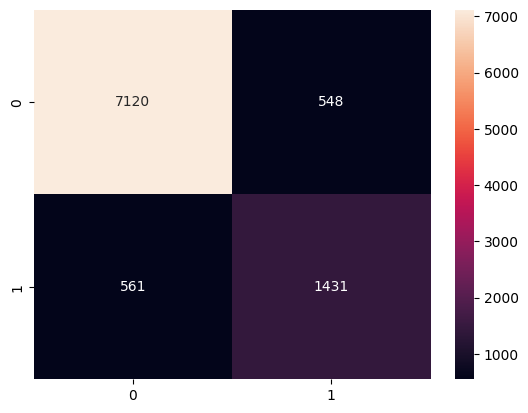

In [ ]:
Confusion_matrix = confusion_matrix(test_targets, test_preds)
print("Confusion Matrix:")
sns.heatmap(Confusion_matrix, annot=True, fmt='d')
plt.show()

In [ ]:
Classification_report = classification_report(test_targets, test_preds, target_names=['No Occupancy', 'Occupancy'], zero_division=0)
print("Classification Report:\n", Classification_report)

# Even though I have calculated class weights, but still the model is biased towards the class occupancy.
# The gap between traning and validation loss is big, because the distribution of Occupancy is different in each DS.

Classification Report:
               precision    recall  f1-score   support

No Occupancy       0.97      0.89      0.93      7668
   Occupancy       0.69      0.89      0.77      1992

    accuracy                           0.89      9660
   macro avg       0.83      0.89      0.85      9660
weighted avg       0.91      0.89      0.90      9660

